In [85]:
import importlib
import easyocr
import pytesseract as tess
import os, sys, time
import multiprocessing as mp
from PIL import Image
from ultralytics import YOLO
from src.components.Detector import UltraDetector
from src.objects.Cascades import FrameTree
from src.config import *
from src.modules.utils import *
from src.modules.preprocess import *
from src.modules.reader import *

importlib.reload(sys.modules['src.components.Detector'])
importlib.reload(sys.modules['src.objects.Cascades'])
importlib.reload(sys.modules['src.modules.utils'])
importlib.reload(sys.modules['src.modules.preprocess'])
importlib.reload(sys.modules['src.modules.reader'])
importlib.reload(sys.modules['src.config'])

<module 'src.config' from 'c:\\users\\user\\projects\\20231019-traffic-management\\src\\config.py'>

In [106]:
car_model = YOLO(WEIGHTS_PATH)
plate_model = YOLO(PLATE_WEIGHTS)
ocr_model = YOLO(OCR_WEIGHTS)
carObj = UltraDetector(model=car_model, classes=CLASSES)
plateObj = UltraDetector(model=plate_model)

UltraDetector.__init__() took 0.0 seconds

UltraDetector.__init__() took 0.0 seconds



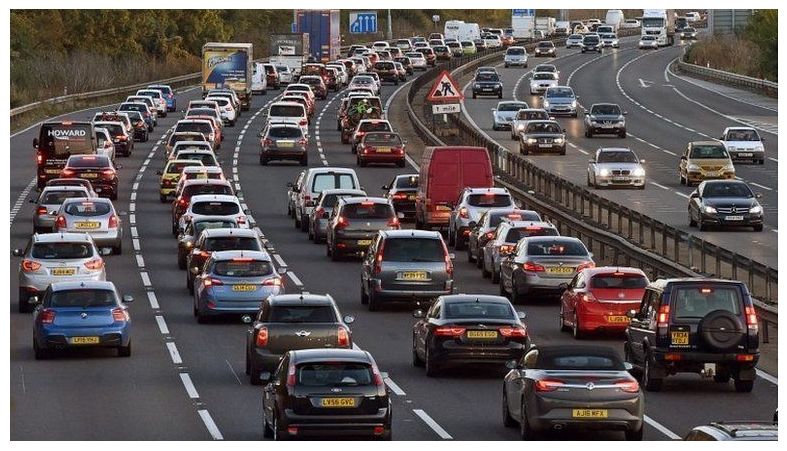

In [170]:
eocr_model = easyocr.Reader(['en'], gpu=True)
img = r'images/cars-4.jpg'
display(image=img)
img = cv2.imread(img)

In [140]:
carObj.Track(frame=img)
plateObj.Track(frame=img)
unionObj = carObj.frame_nodes.deepunion(plateObj.frame_nodes)
unionObj.summarize()
unionObj.save('tree\\unionObj.pkl')


0: 384x640 16 cars, 2 trucks, 357.8ms
Speed: 104.6ms preprocess, 357.8ms inference, 86.2ms postprocess per image at shape (1, 3, 384, 640)




FrameTree Summary
Root Name:  root
Root ID:  -1
Root Shape:  (432, 768, 3)
Root Child Count:  18
Root Depth:  1
Tree Diagram: 
root
├── [1] car
├── [2] car
├── [3] car
├── [4] car
├── [5] car
├── [6] car
├── [7] car
├── [8] car
├── [9] car
├── [10] car
├── [11] car
├── [12] car
├── [13] car
├── [14] car
├── [15] car
├── [16] truck
├── [17] truck
└── [18] car

UltraDetector.Detect() took 2.632230281829834 seconds



0: 384x640 5 license plates, 286.7ms
Speed: 7.4ms preprocess, 286.7ms inference, 6.3ms postprocess per image at shape (1, 3, 384, 640)



FrameTree Summary
Root Name:  root
Root ID:  -1
Root Shape:  (432, 768, 3)
Root Child Count:  5
Root Depth:  1
Tree Diagram: 
root
├── [1] license plate
├── [2] license plate
├── [3] license plate
├── [4] license plate
└── [5] license plate

UltraDetector.Detect() took 0.3346843719482422 seconds


FrameTree Summary
Root Name:  root
Root ID:  -1
Root Shape:  (432, 768, 3)
Root Child Count:  18
Root Depth:  2
Tree Diagram: 
root
├── [1] car
├── [2] car
│       └── [4] license plate
├── [3] car
│       └── [2] license plate
├── [4] car
├── [5] car
│       └── [5] license plate
├── [6] car
├── [7] car
├── [8] car
├── [9] car
├── [10] car
│       └── [1] license plate
├── [11] car
├── [12] car
│       └── [3] license plate
├── [13] car
├── [14] car
├── [15] car
├── [16] truck
├── [17] truck
└── [18] car

Frame Tree saved to: tree\unionObj.pkl


In [141]:
unionObj = FrameTree.load(path='tree\\unionObj.pkl')

Loading Frame Tree from: tree\unionObj.pkl


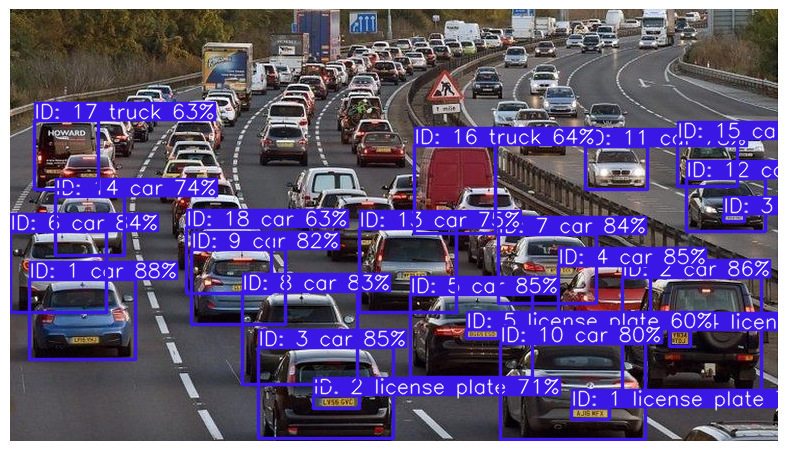

In [160]:
display(unionObj.plot())

In [162]:
plates = unionObj.getChildsByName('license plate')
print(len(plates))

5


In [99]:
def merge_roots(trees, show=False):
    max_width = 0 # find the max width of all the trees
    total_height = 0 # the total height of the trees (vertical stacking)

    for img in trees:
        # open all trees and find their sizes
        # print(p.root.shape[1], p.root.shape[0])
        if img.root.shape[1] > max_width:
            max_width = img.root.shape[1]
        total_height += img.root.shape[0]

    # create a new array with a size large enough to contain all the trees
    final_image = np.zeros((total_height,max_width,3),dtype=np.uint8)

    current_y = 0 # keep track of where your current image was last placed in the y coordinate
    for img in trees:
        # add an image to the final array and increment the y coordinate
        final_image[current_y:img.root.shape[0]+current_y,:img.root.shape[1],:] = img.root
        current_y += img.root.shape[0]

    if show: display(final_image) 
    return final_image

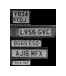

[([[0, 0], [23, 0], [23, 17], [0, 17]], '5', 0.8200932440581745), ([[8, 18], [42, 18], [42, 26], [8, 26]], 'Tgid', 0.014038407243788242), ([[2, 30], [30, 30], [30, 38], [2, 38]], 'At', 0.0076381915626253585), ([[2, 40], [36, 40], [36, 48], [2, 48]], 'IJar o', 0.009170305594086875)]
1.0169668197631836


In [173]:
tess.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
# st = time.time()
# for p in plates:
#     final_image = apply_method(threshold, p.root, show=False)
#     result = eocr_model.readtext(final_image)
#     print(result)
#     # result = tess.image_to_string(final_image, lang='eng')
#     # print(result)
# print(time.time() - st)
st = time.time()
final_image = merge_roots(plates, show=False)
final_image = apply_method(grayscale, final_image, show=True)
# final_image = apply_method(resize, final_image, show=True, min_w=70)
# final_image = apply_method(threshold, final_image, show=True, thresh=110)
# final_image = apply_method(resize, final_image, show=True, min_w=300)
result = eocr_model.readtext(final_image)
print(result)
# result = tess.image_to_string(final_image, lang='eng')
# print(result)
print(time.time() - st)

In [10]:
def plate_unoise(plate):
    plate = plate.replace('  ', ' ')
    plate = plate.replace('.', '')
    plate = plate.replace(',', '')
    plate = plate.replace(':', '')
    plate = plate.replace(';', '')
    plate = plate.replace('!', '')
    plate = plate.replace('?', '')
    return plate

def check_plate_format(formats:Union[list, tuple]=[]):
    """
    formats is an array of plate format with shape (num_line, 1)
    """
    try:
        formats = np.array(formats)
    except:
        raise Exception('Invalid format of attribute "formats". It must be any of (list, tuple)')
    if len(formats) == 0:
        raise Exception('Invalid format of attribute "formats". It must be a list with shape (num_line, 1)')

    format_dict = ['C', 'D', 'S', '-', ' ']
    for i, line in enumerate(formats):
        for j, char in enumerate(line):
            if char not in format_dict:
                print(f'Invalid plate fortmat of {char} at line {i+1} and position {j+1}')
                return False
    return True

In [11]:
formats = ['CCDD CCC']
check_plate_format(formats)

True

Saved image to output\preprocess/image-preprocess.jpg


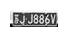

Saved image to output\preprocess/image-preprocess.jpg


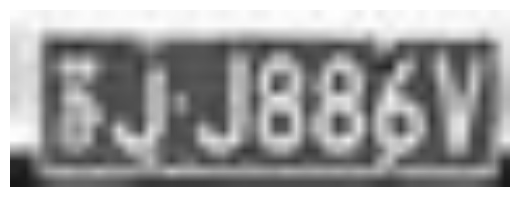

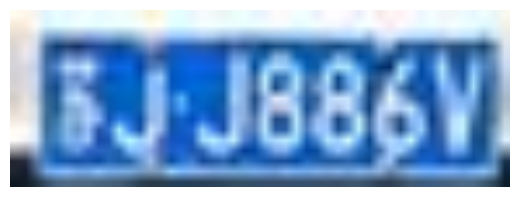

Saved image to output\preprocess/image-preprocess.jpg


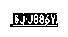

Saved image to output\preprocess/image-preprocess.jpg


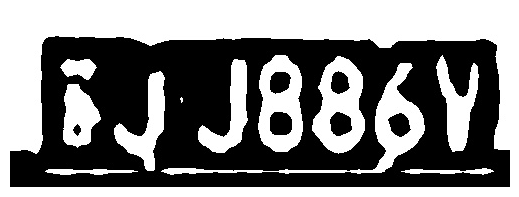

In [15]:
plate_img = plates[1].root
plate_gray = apply_method(grayscale, plate_img)
plate_resize = apply_method(resize, plate_gray)
plate = pipeline(plate_img)
plate_otsu = apply_method(threshold, plate_gray, type=cv2.THRESH_OTSU)
plate_resize_otsu = apply_method(threshold, plate_resize, type=cv2.THRESH_OTSU)

In [16]:
import copy 

def easyocr_predict(img):
    if len(img.shape) == 2:
        img = np.stack((img,)*3, axis=-1) # create 3 channels
    result = eocr_model.readtext(img)
    img_box = copy.deepcopy(img)
    for r in result:
        img_box = draw_boxes(img_box, r)
    display(img_box)
    return result

def draw_boxes(img, r):
    box, text, prob = r
    box = np.array(box).astype(np.int32)  
    pts = np.array(box, np.int32)
    pts = pts.reshape((-1, 1, 2))
    img_box = cv2.polylines(img, [pts], True, (0, 255, 0), 2)
    # print(r)
    # print(img_box.shape)
    start_point = (box[0][0], max(box[0][1]-10, 15))
    cv2.putText(img_box, f'{text} {prob*100:.0f}%', start_point, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 255), 2)
    return img_box

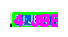

[([[3, 3], [48, 3], [48, 17], [3, 17]], '4 JBBSV', 0.10063229465093051)]


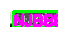

[([[3, 1], [48, 1], [48, 17], [3, 17]], 'NJBBBV', 0.11576154269729412)]


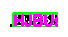

[([[3, 3], [48, 3], [48, 17], [3, 17]], 'HJBUsY', 0.03194928740669862)]


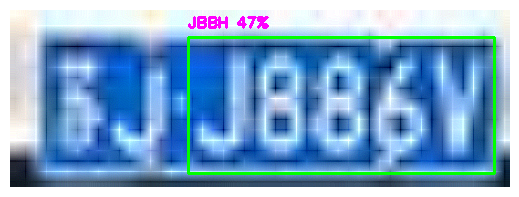

[([[178, 27], [484, 27], [484, 163], [178, 163]], 'JBBH', 0.47046294808387756)]


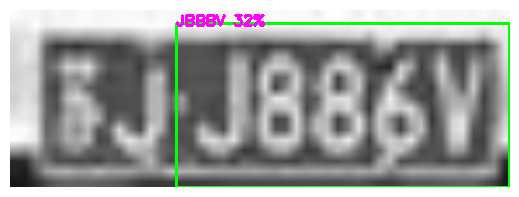

[([[166, 13], [499, 13], [499, 177], [166, 177]], 'JBBBV', 0.3178385225045332)]


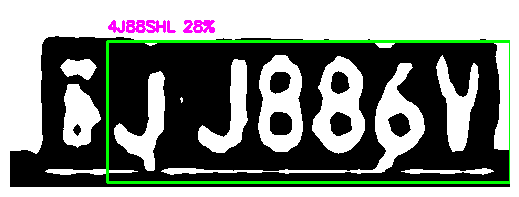

[([[97, 31], [500, 31], [500, 172], [97, 172]], '4J88SHL', 0.2796292776427151)]


In [17]:
print(easyocr_predict(plate_img))
print(easyocr_predict(plate_gray))
print(easyocr_predict(plate_otsu))
print(easyocr_predict(plate))
print(easyocr_predict(plate_resize))
print(easyocr_predict(plate_resize_otsu))